In [2]:
#1.- VERIFICACIÓN DEL ENTORNO DE EJECUCIÓN"
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          5.2                         
year           2025                        
month          10                          
day            31                          
svn rev        88974                       
language       R                           
version.string R version 4.5.2 (2025-10-31)
nickname       [Not] Part in a Rumble      

In [3]:
#2.1.- INSTALACIÓN DE LIBRERÍAS NECESARIAS EN "R"


install.packages(
  c("plm", "fixest", "lmtest", "sandwich",
    "readxl", "dplyr", "ggplot2",
    "broom", "modelsummary"),
  repos = "https://cloud.r-project.org"
)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘miscTools’, ‘rbibutils’, ‘bayestestR’, ‘datawizard’, ‘bdsmatrix’, ‘collapse’, ‘zoo’, ‘maxLik’, ‘Rdpack’, ‘Formula’, ‘numDeriv’, ‘dreamerr’, ‘stringmagic’, ‘checkmate’, ‘insight’, ‘parameters’, ‘performance’, ‘tables’, ‘tinytable’




In [4]:
# 2.2.- CARGAR LIBRERÍAS DISPONIBLES DENTRO DEL ENTORNO "R"

library(plm)
library(fixest)
library(lmtest)
library(sandwich)
library(readxl)
library(dplyr)
library(ggplot2)
library(broom)
library(modelsummary)


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:plm’:

    between, lag, lead


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
# 3. CARGA Y VISUALIZACIÓN DE LOS DATOS ORIGINALES

library(readxl)

data <- read_excel("LONG_EC_UNIFICADA_TFM.xlsx")
head(data)



COUNTRY,YEAR,Yit,X1it,X2it,Z1it,Z2it,Z3it,Z4it
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,2013,34310.7,6.7030236899999998E-2,3.4369508600000001E-2,83.0,23.3,2.98,102.9
Austria,2014,34668.8,6.7030236899999998E-2,:,83.9,23.0,3.11,103.7
Austria,2015,35681.6,6.6921165800000001E-2,:,84.6,22.9,3.07,104.9
Austria,2016,36385.4,6.65454766E-2,:,84.5,23.3,3.13,106.0
Austria,2017,37011.9,6.6981760900000006E-2,:,85.0,23.8,3.07,106.8
Austria,2018,38414.6,6.6966395600000006E-2,:,85.3,24.3,3.11,107.1


In [19]:
library(dplyr)

# 3. OBETENER LOS NOMBRES ACTUALES DE LAS COLUMNAS
current_cols <- colnames(data)
print(current_cols)

# 3.1. Asegurar que data sea un tibble para compatibilidad con dplyr
data <- as_tibble(data)

# 3.2. Definir un vector con los nombres antiguos y sus correspondientes nuevos nombres
old_to_new_names <- c(
    COUNTRY = "Country",
    YEAR = "Year",
    Yit = "y",          # variable dependiente
    X1it = "x1",
    X2it = "x2",
    Z1it = "z1",
    Z2it = "z2",
    Z3it = "z3",
    Z4it = "z4"
)

# 3.3. Filtrar solo los renombres que sean aplicables (donde el nombre antiguo aún existe)
valid_renames_list <- list()
for (old_name in names(old_to_new_names)) {
  if (old_name %in% current_cols) {
    valid_renames_list[[old_to_new_names[[old_name]]]] <- old_name
  }
}

# 3.4. Convertir la lista a un formato compatible con `rename()`
# Usamos `!!!` para unquote splice la lista de renombres
if (length(valid_renames_list) > 0) {
  data <- data %>%
    rename(!!!valid_renames_list)
} else {
  message("Advertencia: No se encontraron columnas originales para renombrar o ya estaban renombradas.")
}

# 3.5. Imprimir los nombres de las columnas después del renombramiento (o intento de renombramiento)
colnames(data)

 [1] "Country"   "Year"      "y"         "x1"        "x2"        "z1"       
 [7] "z2"        "z3"        "z4"        "ln_y"      "ln_x1"     "ln_x2"    
[13] "ln_z1"     "ln_z2"     "ln_z3"     "ln_z4"     "ln_x2_lag" "ln_z2_lag"


Advertencia: No se encontraron columnas originales para renombrar o ya estaban renombradas.



[1] "Country"   "Year"      "y"         "x1"        "x2"        "z1"       
 [7] "z2"        "z3"        "z4"        "ln_y"      "ln_x1"     "ln_x2"    
[13] "ln_z1"     "ln_z2"     "ln_z3"     "ln_z4"     "ln_x2_lag" "ln_z2_lag"

In [20]:
# 4. LIMPIEZA DE DATOS Y CONVERSIÓN A NUMÉRICO

library(dplyr)

# 4.1. Limpieza básica y conversión a numérico
data <- data %>%
  # 4.1.1) Pasar ":" a NA (por si vienen como texto)
  mutate(across(c(y, x1, x2, z1, z2, z3, z4),
                ~na_if(as.character(.), ":"))) %>%
  # 4.1.2) Convertir a numérico
  mutate(across(c(y, x1, x2, z1, z2, z3, z4),
                ~as.numeric(.)))

# 4.2. Revisar rápidamente
summary(data)
str(data)



   Country               Year            y               x1         
 Length:297         Min.   :2013   Min.   :12194   Min.   :0.01401  
 Class :character   1st Qu.:2015   1st Qu.:21994   1st Qu.:0.02979  
 Mode  :character   Median :2018   Median :28489   Median :0.04682  
                    Mean   :2018   Mean   :31384   Mean   :0.05697  
                    3rd Qu.:2021   3rd Qu.:35819   3rd Qu.:0.07449  
                    Max.   :2023   Max.   :93489   Max.   :0.12397  
                                                   NA's   :22       
       x2                 z1              z2              z3       
 Min.   :0.000145   Min.   :39.80   Min.   :11.00   Min.   :0.380  
 1st Qu.:0.003286   1st Qu.:78.10   1st Qu.:19.00   1st Qu.:0.950  
 Median :0.010892   Median :83.20   Median :21.20   Median :1.390  
 Mean   :0.019940   Mean   :80.72   Mean   :21.32   Mean   :1.655  
 3rd Qu.:0.022562   3rd Qu.:88.40   3rd Qu.:23.70   3rd Qu.:2.220  
 Max.   :0.103590   Max.   :95.40   Max.

tibble [297 × 18] (S3: tbl_df/tbl/data.frame)
 $ Country  : chr [1:297] "Austria" "Austria" "Austria" "Austria" ...
 $ Year     : num [1:297] 2013 2014 2015 2016 2017 ...
 $ y        : num [1:297] 34311 34669 35682 36385 37012 ...
 $ x1       : num [1:297] 0.067 0.067 0.0669 0.0665 0.067 ...
 $ x2       : num [1:297] 0.0344 NA NA NA NA ...
 $ z1       : num [1:297] 83 83.9 84.6 84.5 85 85.3 85.6 85.7 85.9 85.9 ...
 $ z2       : num [1:297] 23.3 23 22.9 23.3 23.8 24.3 25.1 25.1 25.9 25.2 ...
 $ z3       : num [1:297] 2.98 3.11 3.07 3.13 3.07 3.11 3.14 3.21 3.26 3.18 ...
 $ z4       : num [1:297] 103 104 105 106 107 ...
 $ ln_y     : num [1:297] 10.4 10.5 10.5 10.5 10.5 ...
 $ ln_x1    : num [1:297] -2.7 -2.7 -2.7 -2.71 -2.7 ...
 $ ln_x2    : num [1:297] -3.37 NA NA NA NA ...
 $ ln_z1    : num [1:297] 4.42 4.43 4.44 4.44 4.44 ...
 $ ln_z2    : num [1:297] 3.15 3.14 3.13 3.15 3.17 ...
 $ ln_z3    : num [1:297] 1.09 1.13 1.12 1.14 1.12 ...
 $ ln_z4    : num [1:297] 4.63 4.64 4.65 4.66 4.67

In [21]:
# 5. CREAR LOGARÍTMOS Y REZAGOS

library(dplyr)

# 5.1. Evitar problemas con log(0) o valores negativos:
#    Si alguna de estas variables es 0 o <0, la pasamos a NA
data <- data %>%
  mutate(across(c(y, x1, x2, z1, z2, z3, z4),
                ~ ifelse(. <= 0, NA, .)))

# 5.2. Crear logaritmos y rezagos por país
data <- data %>%
  group_by(Country) %>%
  mutate(
    ln_y   = log(y),
    ln_x1  = log(x1),
    ln_x2  = log(x2),      # Intensidad intermodal
    ln_z1  = log(z1),
    ln_z2  = log(z2),
    ln_z3  = log(z3),
    ln_z4  = log(z4),

    # 5.2.1. Rezagos (ajustamos a lo que usas en la ecuación del TFM)
    ln_x2_lag = lag(ln_x2, 1),   # intensidad intermodal t-1
    ln_z2_lag = lag(ln_z2, 1)    # por ejemplo, rezago de Z2
  ) %>%
  ungroup()

# 5.3. Verificar que se han creado bien
summary(select(data, ln_y, ln_x1, ln_x2, ln_z1, ln_z2, ln_z3, ln_z4,
               ln_x2_lag, ln_z2_lag))


      ln_y            ln_x1            ln_x2            ln_z1      
 Min.   : 9.409   Min.   :-4.268   Min.   :-8.842   Min.   :3.684  
 1st Qu.: 9.999   1st Qu.:-3.514   1st Qu.:-5.718   1st Qu.:4.358  
 Median :10.257   Median :-3.061   Median :-4.520   Median :4.421  
 Mean   :10.278   Mean   :-3.021   Mean   :-4.765   Mean   :4.378  
 3rd Qu.:10.486   3rd Qu.:-2.597   3rd Qu.:-3.791   3rd Qu.:4.482  
 Max.   :11.446   Max.   :-2.088   Max.   :-2.267   Max.   :4.558  
                  NA's   :22       NA's   :56                      
     ln_z2           ln_z3              ln_z4         ln_x2_lag     
 Min.   :2.398   Min.   :-0.96758   Min.   :2.885   Min.   :-8.408  
 1st Qu.:2.944   1st Qu.:-0.05129   1st Qu.:4.275   1st Qu.:-5.732  
 Median :3.054   Median : 0.32930   Median :4.655   Median :-4.553  
 Mean   :3.042   Mean   : 0.35219   Mean   :4.662   Mean   :-4.769  
 3rd Qu.:3.165   3rd Qu.: 0.79751   3rd Qu.:4.929   3rd Qu.:-3.803  
 Max.   :3.974   Max.   : 1.29198   Max.  

In [22]:
# 6. CONSTRUCCIÓN DEL PANEL Y ESTIMACIÓN DEL MODELO FE TWO-WAYS

library(dplyr)
library(plm)
library(lmtest)
library(sandwich)

# 6.1. Filtramos solo las observaciones completas para el modelo
panel <- data %>%
  filter(
    !is.na(ln_y),
    !is.na(ln_x2_lag),
    !is.na(ln_x1),
    !is.na(ln_z1),
    !is.na(ln_z2_lag),
    !is.na(ln_z3),
    !is.na(ln_z4)
  )

# 6.1.1. Ver cuántas observaciones quedan
nrow(panel)
length(unique(panel$Country))
length(unique(panel$Year))

# 6.2. Definir datos de panel
pdata <- pdata.frame(panel, index = c("Country", "Year"))

# 6.3. Modelo de efectos fijos two-ways
fe_tw <- plm(
  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4,
  data   = pdata,
  model  = "within",
  effect = "twoways"
)

summary(fe_tw)

# 6.4. Errores robustos cluster por país
coeftest(fe_tw, vcov = vcovHC(fe_tw, type = "HC1", cluster = "group"))



[1] 219

[1] 24

[1] 10

Twoways effects Within Model

Call:
plm(formula = ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + 
    ln_z3 + ln_z4, data = pdata, effect = "twoways", model = "within")

Unbalanced Panel: n = 24, T = 1-10, N = 219

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.3156629 -0.0217385 -0.0003032  0.0261117  0.2047075 

Coefficients:
            Estimate Std. Error t-value Pr(>|t|)    
ln_x2_lag -0.0403571  0.0120943 -3.3369 0.001029 ** 
ln_x1      0.0668198  0.1752664  0.3812 0.703469    
ln_z1     -0.0038911  0.1607488 -0.0242 0.980715    
ln_z2_lag  0.0161668  0.0408493  0.3958 0.692745    
ln_z3      0.0132871  0.0412741  0.3219 0.747885    
ln_z4     -1.0024686  0.1891229 -5.3006 3.35e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.54688
Residual Sum of Squares: 0.46343
R-Squared:      0.15258
Adj. R-Squared: -0.026317
F-statistic: 5.40167 on 6 and 180 DF, p-value: 3.7191e-05


t test of coefficients:

            Estimate Std. Error t value Pr(>|t|)  
ln_x2_lag -0.0403571  0.0217011 -1.8597  0.06456 .
ln_x1      0.0668198  0.1574150  0.4245  0.67172  
ln_z1     -0.0038911  0.3110630 -0.0125  0.99003  
ln_z2_lag  0.0161668  0.0452354  0.3574  0.72122  
ln_z3      0.0132871  0.0606523  0.2191  0.82684  
ln_z4     -1.0024686  0.6068316 -1.6520  0.10028  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [23]:
# 6.5. CHECK ACERCA DE LA CONSTRUCCIÓN DEL PANEL Y ESTIMACIÓN DEL MODELO FE TWO-WAYS
nrow(panel)
length(unique(panel$Country))
length(unique(panel$Year))


[1] 219

[1] 24

[1] 10

In [25]:


library(plm)
library(lmtest)
library(sandwich)

# Definir pdata
pdata <- pdata.frame(panel, index = c("Country", "Year"))

# 6.6. MODELO FE TWO-WAYS (PAÍS Y AÑO)
fe_tw <- plm(
  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4,
  data   = pdata,
  model  = "within",
  effect = "twoways"
)

# Resumen estándar
summary(fe_tw)

# 6.7. ERRORES ROBUSTOS AGRUPADOS POR PAÍS
fe_tw_rob <- coeftest(
  fe_tw,
  vcov = vcovHC(fe_tw, type = "HC1", cluster = "group")
)

fe_tw_rob


Twoways effects Within Model

Call:
plm(formula = ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + 
    ln_z3 + ln_z4, data = pdata, effect = "twoways", model = "within")

Unbalanced Panel: n = 24, T = 1-10, N = 219

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.3156629 -0.0217385 -0.0003032  0.0261117  0.2047075 

Coefficients:
            Estimate Std. Error t-value Pr(>|t|)    
ln_x2_lag -0.0403571  0.0120943 -3.3369 0.001029 ** 
ln_x1      0.0668198  0.1752664  0.3812 0.703469    
ln_z1     -0.0038911  0.1607488 -0.0242 0.980715    
ln_z2_lag  0.0161668  0.0408493  0.3958 0.692745    
ln_z3      0.0132871  0.0412741  0.3219 0.747885    
ln_z4     -1.0024686  0.1891229 -5.3006 3.35e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.54688
Residual Sum of Squares: 0.46343
R-Squared:      0.15258
Adj. R-Squared: -0.026317
F-statistic: 5.40167 on 6 and 180 DF, p-value: 3.7191e-05


t test of coefficients:

            Estimate Std. Error t value Pr(>|t|)  
ln_x2_lag -0.0403571  0.0217011 -1.8597  0.06456 .
ln_x1      0.0668198  0.1574150  0.4245  0.67172  
ln_z1     -0.0038911  0.3110630 -0.0125  0.99003  
ln_z2_lag  0.0161668  0.0452354  0.3574  0.72122  
ln_z3      0.0132871  0.0606523  0.2191  0.82684  
ln_z4     -1.0024686  0.6068316 -1.6520  0.10028  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [26]:
# 7. POOLING Y EFECTOS ALEATORIOS

# PASO 7.1: MODELO POOLED OLS
pool <- plm(
  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4,
  data  = pdata,
  model = "pooling"
)

summary(pool)

# PASO 7.2: MODELO DE EFECTOS ALEATORIOS
re <- plm(
  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4,
  data  = pdata,
  model = "random"
)

summary(re)


Pooling Model

Call:
plm(formula = ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + 
    ln_z3 + ln_z4, data = pdata, model = "pooling")

Unbalanced Panel: n = 24, T = 1-10, N = 219

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.6245495 -0.1252067 -0.0074824  0.1104995  1.3836756 

Coefficients:
             Estimate Std. Error t-value  Pr(>|t|)    
(Intercept)  2.198876   0.956412  2.2991  0.022474 *  
ln_x2_lag   -0.044973   0.018208 -2.4699  0.014303 *  
ln_x1       -0.387732   0.066939 -5.7923 2.483e-08 ***
ln_z1        0.442990   0.134136  3.3026  0.001124 ** 
ln_z2_lag    0.877717   0.091301  9.6135 < 2.2e-16 ***
ln_z3        0.380400   0.030632 12.4182 < 2.2e-16 ***
ln_z4        0.416255   0.043302  9.6129 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    24.408
Residual Sum of Squares: 9.5083
R-Squared:      0.61044
Adj. R-Squared: 0.59942
F-statistic: 55.3683 on 6 and 212 DF, p-value: < 2.22e-16

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + 
    ln_z3 + ln_z4, data = pdata, model = "random")

Unbalanced Panel: n = 24, T = 1-10, N = 219

Effects:
                  var std.dev share
idiosyncratic 0.01279 0.11308 0.279
individual    0.03297 0.18157 0.721
theta:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4713  0.8068  0.8068  0.8025  0.8068  0.8068 

Residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.33294 -0.07404 -0.01620 -0.00519  0.06312  0.68290 

Coefficients:
             Estimate Std. Error z-value  Pr(>|z|)    
(Intercept)  2.035085   1.570625  1.2957 0.1950730    
ln_x2_lag    0.041934   0.022857  1.8346 0.0665644 .  
ln_x1       -0.357511   0.125475 -2.8493 0.0043819 ** 
ln_z1        1.132140   0.252062  4.4915 7.072e-06 ***
ln_z2_lag    0.238002   0.090005  2.6443 0.0081853 ** 
ln_z3        0.310597   0.064951  4.7820 1.736e-06 ***
ln_z4   

In [27]:
# PASO 7.3: TEST DE HAUSMAN FE vs RE
hausman <- phtest(fe_tw, re)
hausman



	Hausman Test

data:  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4
chisq = 210.28, df = 6, p-value < 2.2e-16
alternative hypothesis: one model is inconsistent


In [30]:
# 7.4.0. Instalar stargazer (solo hace falta una vez por sesión)
install.packages("stargazer")

# Carga del paquete
library(stargazer)

# 7.4 TABLA COMPARATIVA FE vs. POOLING vs RE
stargazer(fe_tw, pool, re,
          type = "text",                      # "latex" cuando lo copies al TFM
          column.labels = c("FE two-ways", "Pooling", "RE"),
          dep.var.labels = "ln(PIB pc, PPS)",
          title = "Comparación de especificaciones de panel")



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 





Comparación de especificaciones de panel
                                Dependent variable:                   
             ---------------------------------------------------------
                                  ln(PIB pc, PPS)                     
                  FE two-ways               Pooling             RE    
                      (1)                     (2)              (3)    
----------------------------------------------------------------------
ln_x2_lag          -0.040***               -0.045**           0.042*  
                    (0.012)                 (0.018)          (0.023)  
                                                                      
ln_x1                0.067                 -0.388***        -0.358*** 
                    (0.175)                 (0.067)          (0.125)  
                                                                      
ln_z1                -0.004                0.443***          1.132*** 
                    (0.161)        

In [31]:
# 8. TEST DE DEPENDENCIA TRANSVERSAL (PESARAN CD) PARA FE TWO-WAYS
library(plm)

cd_fe <- pcdtest(fe_tw)
cd_fe


Warning message in pcdres(tres = tres, n = n, w = w, form = paste(deparse(x$formula)), :
“Some pairs of individuals (33 percent) do not have any or just one time period in common and have been omitted from calculation”



	Pesaran CD test for cross-sectional dependence in panels

data:  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4
z = -0.87535, p-value = 0.3814
alternative hypothesis: cross-sectional dependence


In [33]:
# 9. TEST FE vs. POOLING (pFTEST)

pFtest(fe_tw, pool)






	F test for twoways effects

data:  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4
F = 109.78, df1 = 32, df2 = 180, p-value < 2.2e-16
alternative hypothesis: significant effects


In [35]:
# 10. AUTOCORRELACIÓN EN EL MODELO FE

pbgtest(fe_tw)



	Breusch-Godfrey/Wooldridge test for serial correlation in panel models

data:  ln_y ~ ln_x2_lag + ln_x1 + ln_z1 + ln_z2_lag + ln_z3 + ln_z4
chisq = 63.149, df = 1, p-value = 1.916e-15
alternative hypothesis: serial correlation in idiosyncratic errors


In [73]:
# 11. MODELO FE PARSIMONIOSO (QUITANDO DEL MODELO ln_z1)
fe_pars <- plm(
  ln_y ~ ln_x2_lag + ln_x1 + ln_z2_lag + ln_z3 + ln_z4,
  data   = pdata,
  model  = "within",
  effect = "twoways"
)

# 11.1. Errores robustos agrupados por país
fe_pars_rob <- coeftest(
  fe_pars,
  vcov = vcovHC(fe_pars, type = "HC1", cluster = "group")
)

summary(fe_pars)
fe_pars_rob


Twoways effects Within Model

Call:
plm(formula = ln_y ~ ln_x2_lag + ln_x1 + ln_z2_lag + ln_z3 + 
    ln_z4, data = pdata, effect = "twoways", model = "within")

Unbalanced Panel: n = 24, T = 1-10, N = 219

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.31565051 -0.02173046 -0.00024087  0.02610674  0.20460487 

Coefficients:
           Estimate Std. Error t-value  Pr(>|t|)    
ln_x2_lag -0.040392   0.011974 -3.3733 0.0009084 ***
ln_x1      0.067288   0.173714  0.3873 0.6989524    
ln_z2_lag  0.015943   0.039682  0.4018 0.6883213    
ln_z3      0.013036   0.039840  0.3272 0.7438869    
ln_z4     -1.002626   0.188488 -5.3193 3.049e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.54688
Residual Sum of Squares: 0.46343
R-Squared:      0.15258
Adj. R-Squared: -0.02065
F-statistic: 6.51788 on 5 and 181 DF, p-value: 1.3408e-05


t test of coefficients:

           Estimate Std. Error t value Pr(>|t|)  
ln_x2_lag -0.040392   0.020541 -1.9664  0.05078 .
ln_x1      0.067288   0.154651  0.4351  0.66401  
ln_z2_lag  0.015943   0.046083  0.3460  0.72977  
ln_z3      0.013036   0.056635  0.2302  0.81821  
ln_z4     -1.002626   0.607937 -1.6492  0.10084  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


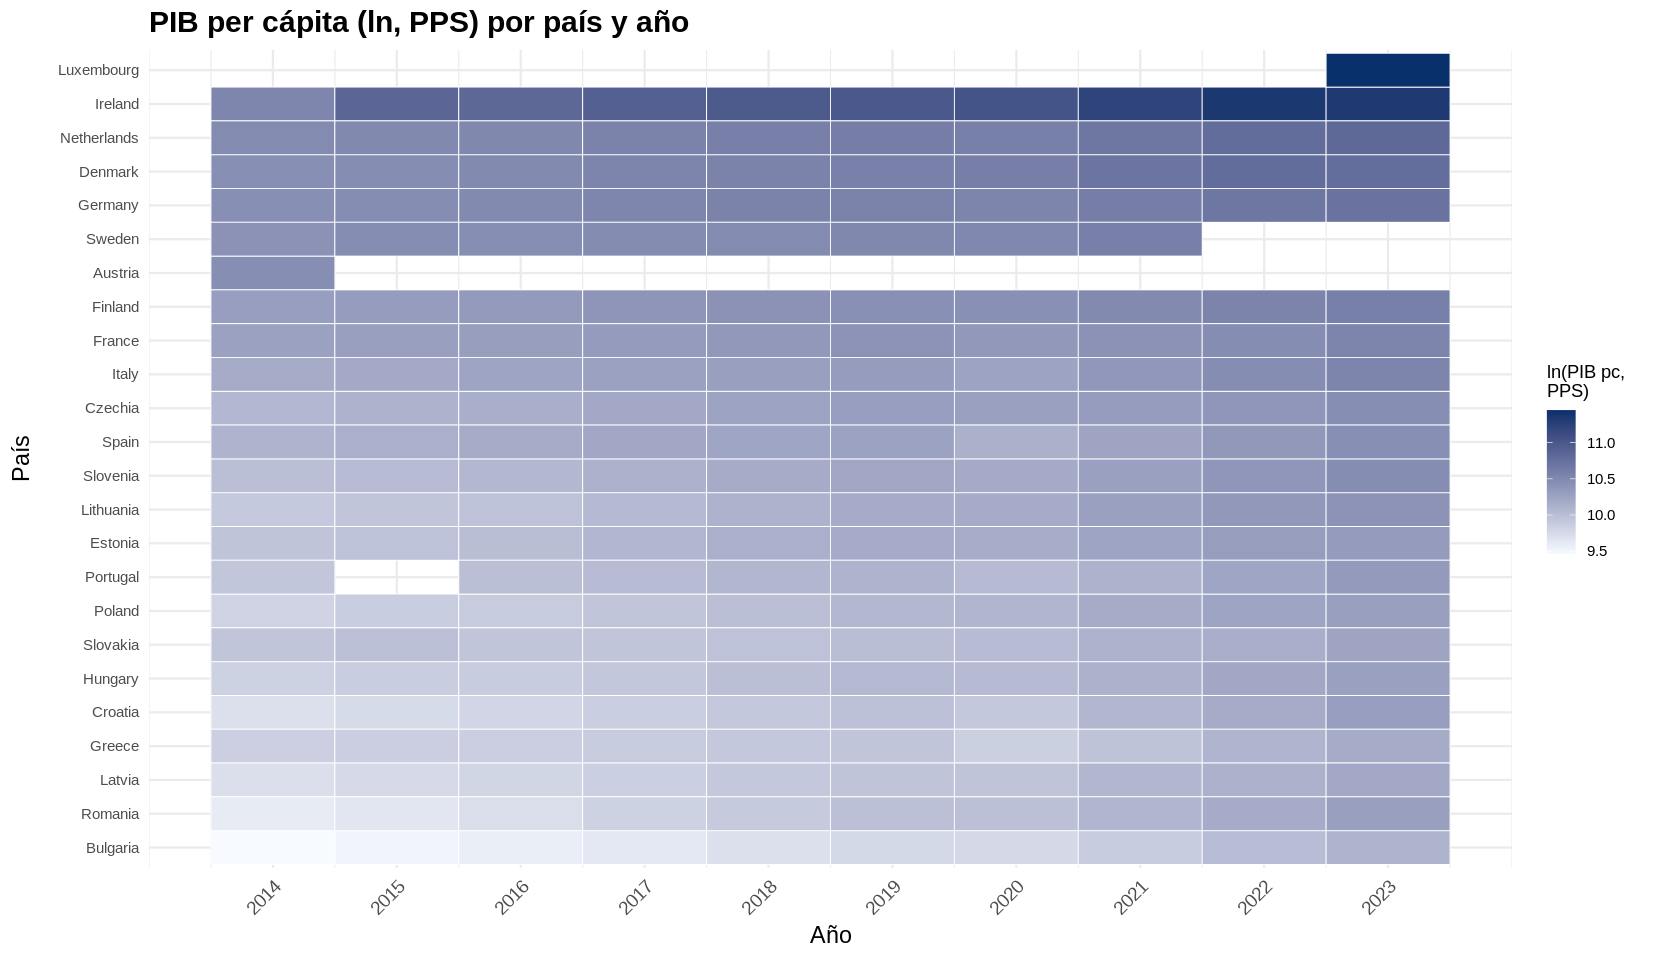

In [86]:
# 12. GRÁFICOS DESCRIPTIVOS

# 12.1. Mapa de calor del PIB per cápita (ln_y) por país y año

library(dplyr)
library(ggplot2)

options(repr.plot.width = 14, repr.plot.height = 8)

# 12.1.1) Preparamos los datos: un valor por país y año
heat_y <- panel %>%
  filter(!is.na(ln_y)) %>%
  group_by(Country, Year) %>%
  summarise(ln_y = mean(ln_y, na.rm = TRUE), .groups = "drop")

# 12.1.2) Ordenamos países de menor a mayor PIB medio (ln_y)
country_order_y <- heat_y %>%
  group_by(Country) %>%
  summarise(mean_ln_y = mean(ln_y, na.rm = TRUE), .groups = "drop") %>%
  arrange(mean_ln_y)

heat_y$Country <- factor(
  heat_y$Country,
  levels = country_order_y$Country
)

# 12.1.3) Mapa de calor
ggplot(heat_y, aes(x = Year, y = Country, fill = ln_y)) +
  geom_tile(color = "white") +
  labs(
    title = "PIB per cápita (ln, PPS) por país y año",
    x = "Año",
    y = "País",
    fill = "ln(PIB pc,\nPPS)"
  ) +
  scale_x_continuous(breaks = sort(unique(heat_y$Year))) +
  scale_fill_gradient(
    low  = "#f7fbff",
    high = "#08306b"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y   = element_text(size = 9),
    axis.text.x   = element_text(angle = 45, hjust = 1),
    plot.title    = element_text(size = 18, face = "bold"),
    legend.title  = element_text(size = 11),
    legend.text   = element_text(size = 9)
  )






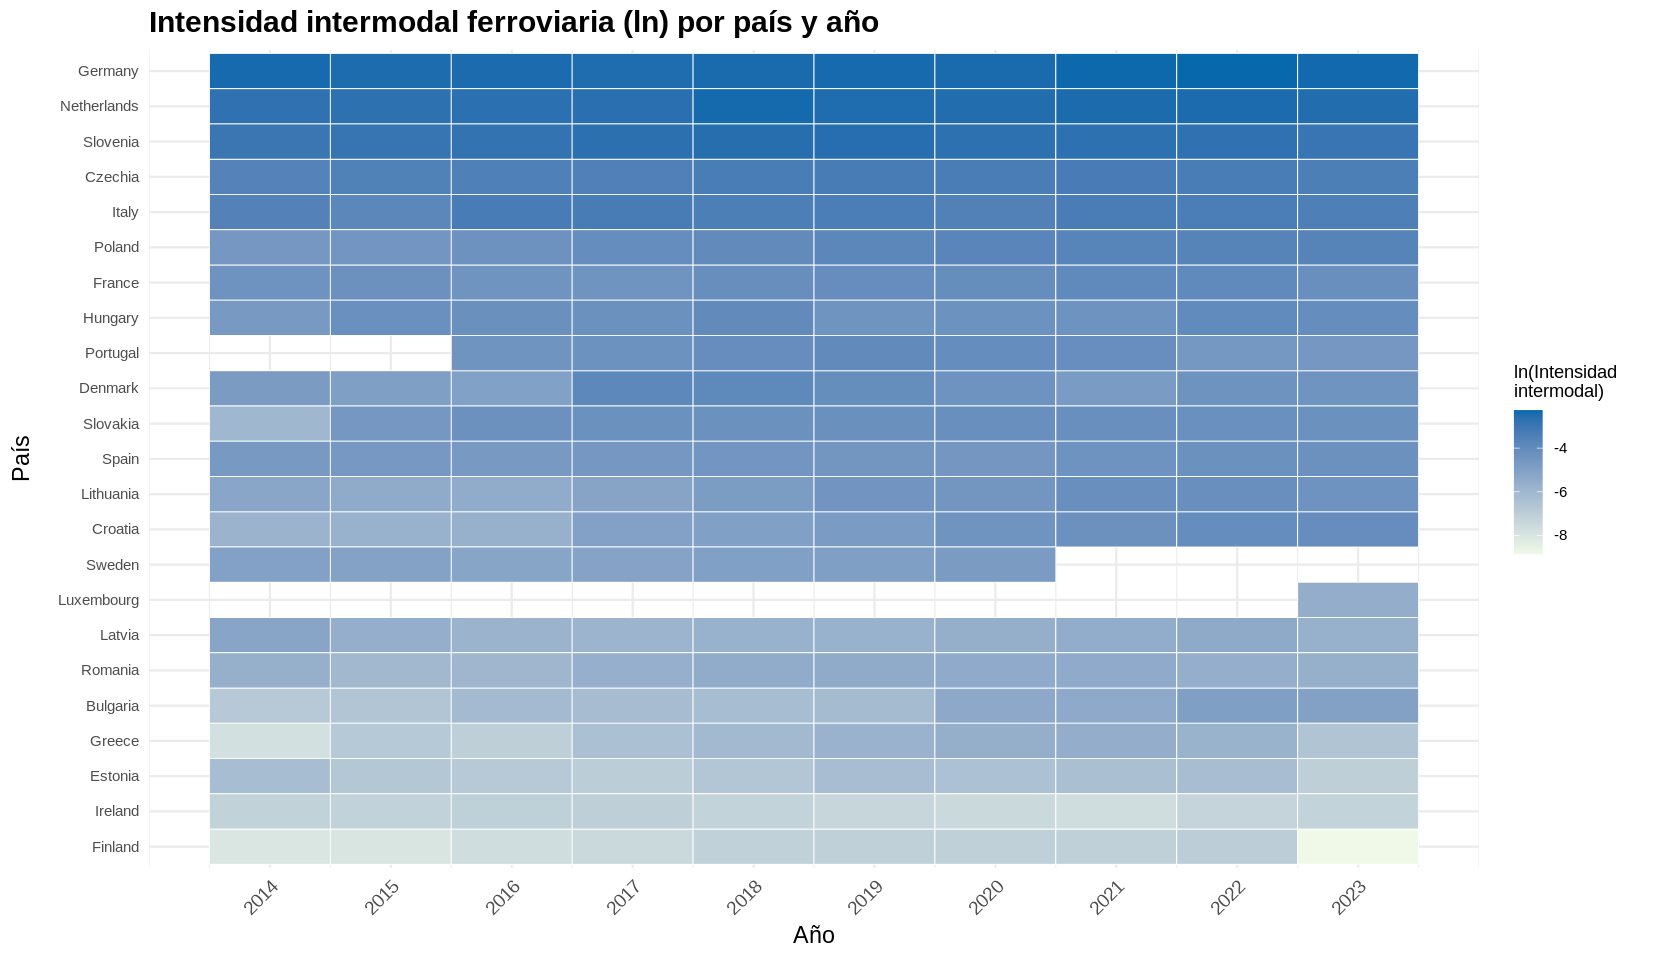

In [85]:
# 12.2. Mapa de calor de la intensidad intermodal (ln_x2) por país y año

library(dplyr)
library(ggplot2)

# 12.2.1) Aseguramos tamaño cómodo del gráfico
options(repr.plot.width = 14, repr.plot.height = 8)

# 12.2.2) Preparamos los datos: un valor por país y año
heat_df <- panel %>%
  filter(!is.na(ln_x2)) %>%
  group_by(Country, Year) %>%
  summarise(ln_x2 = mean(ln_x2, na.rm = TRUE), .groups = "drop")

# 12.2.3) Ordenamos los países de menor a mayor intensidad media
country_order <- heat_df %>%
  group_by(Country) %>%
  summarise(mean_ln_x2 = mean(ln_x2, na.rm = TRUE), .groups = "drop") %>%
  arrange(mean_ln_x2)

heat_df$Country <- factor(
  heat_df$Country,
  levels = country_order$Country
)

# 12.2.4) Mapa de calor país–año
ggplot(heat_df, aes(x = Year, y = Country, fill = ln_x2)) +
  geom_tile(color = "white") +
  labs(
    title = "Intensidad intermodal ferroviaria (ln) por país y año",
    x = "Año",
    y = "País",
    fill = "ln(Intensidad\nintermodal)"
  ) +
  scale_x_continuous(breaks = sort(unique(heat_df$Year))) +
  scale_fill_gradient(
    low  = "#f0f9e8",
    high = "#0868ac"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y   = element_text(size = 9),
    axis.text.x   = element_text(angle = 45, hjust = 1),
    plot.title    = element_text(size = 18, face = "bold"),
    legend.title  = element_text(size = 11),
    legend.text   = element_text(size = 9)
  )




`geom_smooth()` using formula = 'y ~ x'


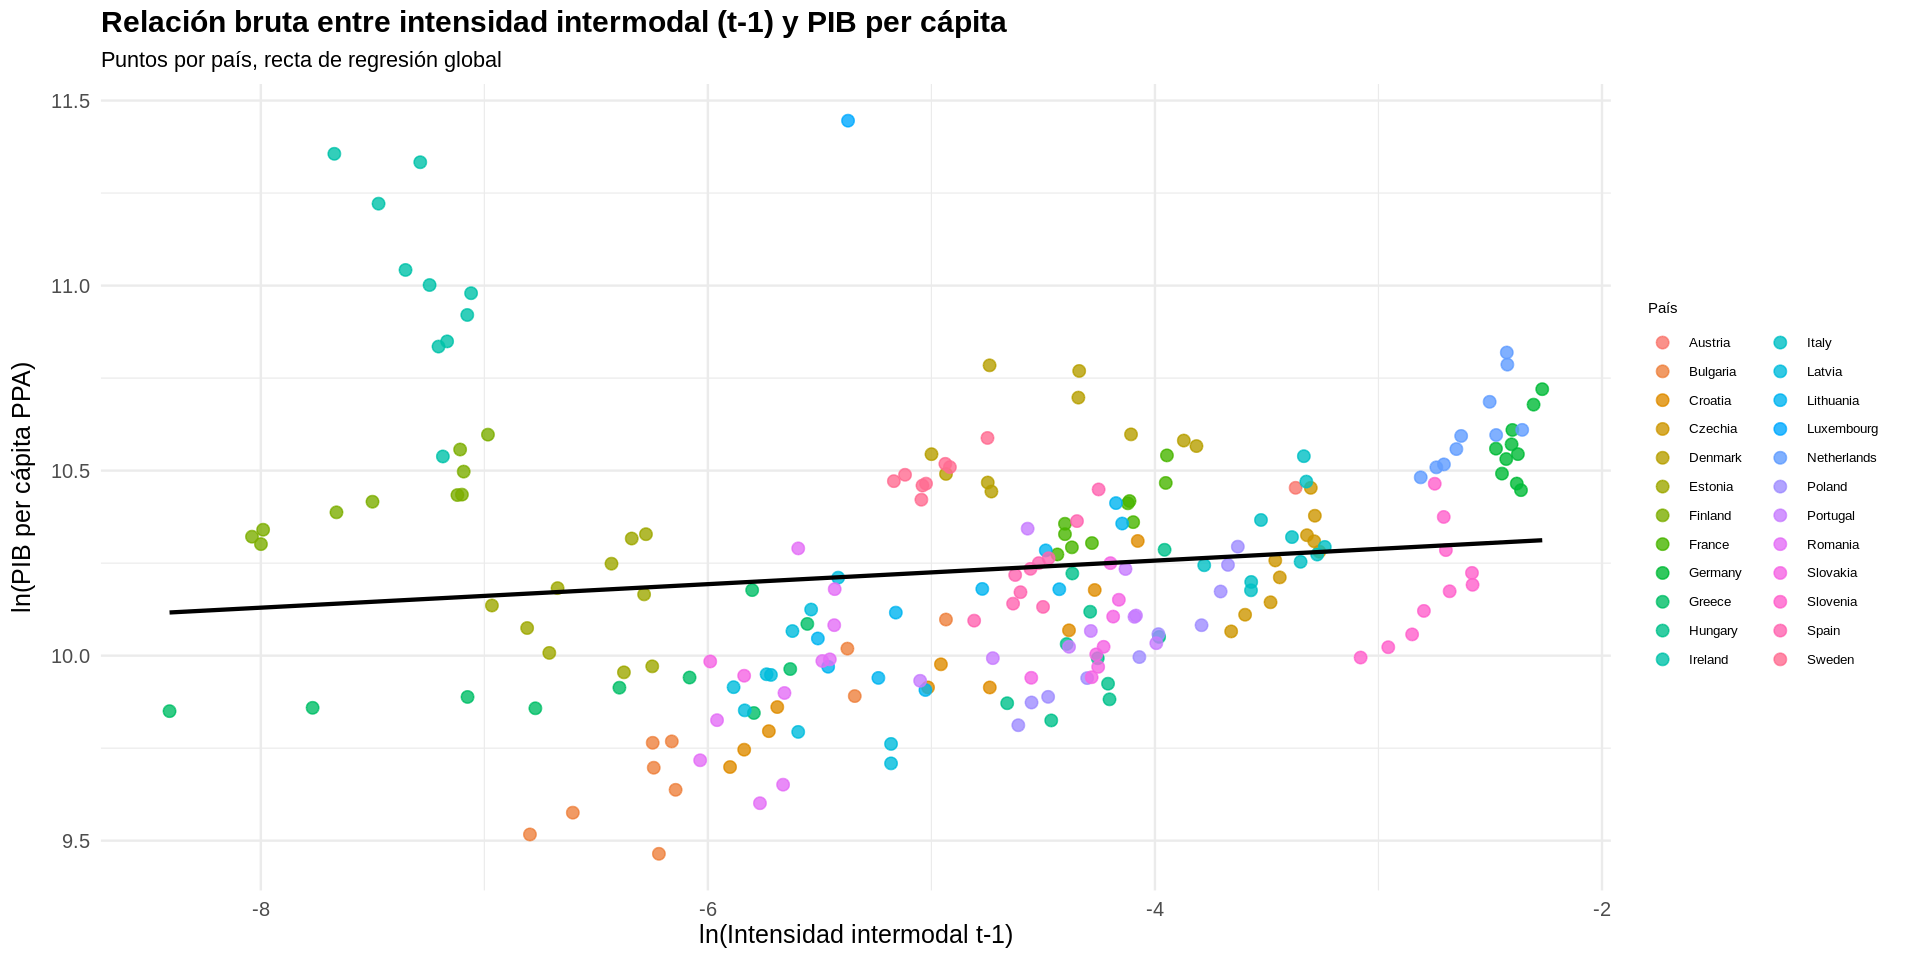

In [65]:
# 12.3. Dispersión ln_x2_lag vs ln_y
# (Relación “en bruto” antes de controlar por efectos fijos y controles.)

options(repr.plot.width = 16, repr.plot.height = 8)   # <-- más ancho y grande

ggplot(panel, aes(x = ln_x2_lag, y = ln_y, color = Country)) +
  geom_point(alpha = 0.8, size = 3) +
  geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 1.2) +
  labs(
    title    = "Relación bruta entre intensidad intermodal (t-1) y PIB per cápita",
    subtitle = "Puntos por país, recta de regresión global",
    x        = "ln(Intensidad intermodal t-1)",
    y        = "ln(PIB per cápita PPA)",
    color    = "País"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title    = element_text(size = 18, face = "bold"),
    plot.subtitle = element_text(size = 13),
    legend.position = "right",
    legend.text   = element_text(size = 8),
    legend.title  = element_text(size = 9)
  )



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


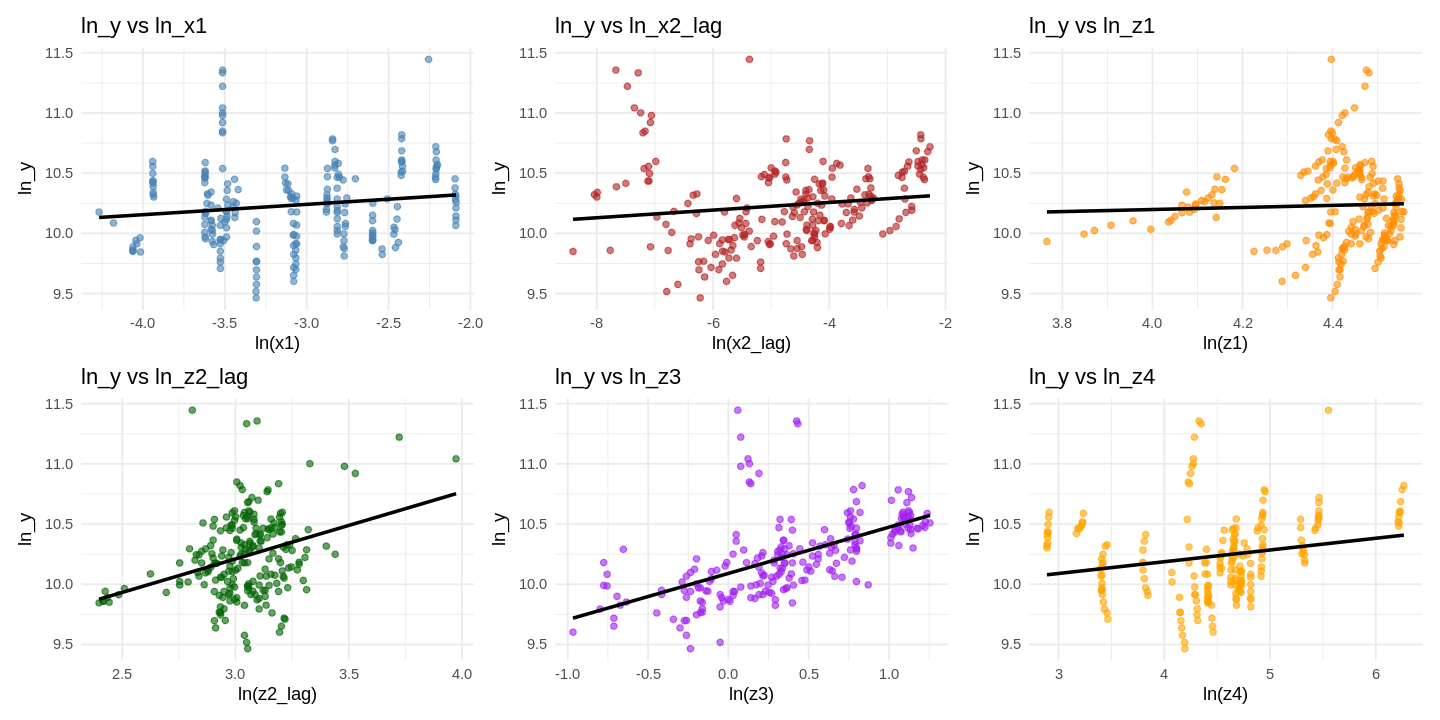

In [82]:
# 12.4. NUBES DE PUNTOS ln_y vs cada regresor (X1, X2, Z1, Z2_lag, Z3, Z4)

library(ggplot2)
library(patchwork)

g1 <- ggplot(panel, aes(x = ln_x1, y = ln_y)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "ln_y vs ln_x1", x = "ln(x1)", y = "ln_y") +
  theme_minimal()

g2 <- ggplot(panel, aes(x = ln_x2_lag, y = ln_y)) +
  geom_point(alpha = 0.6, color = "firebrick") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "ln_y vs ln_x2_lag", x = "ln(x2_lag)", y = "ln_y") +
  theme_minimal()

g3 <- ggplot(panel, aes(x = ln_z1, y = ln_y)) +
  geom_point(alpha = 0.6, color = "darkorange") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "ln_y vs ln_z1", x = "ln(z1)", y = "ln_y") +
  theme_minimal()

g4 <- ggplot(panel, aes(x = ln_z2_lag, y = ln_y)) +
  geom_point(alpha = 0.6, color = "darkgreen") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "ln_y vs ln_z2_lag", x = "ln(z2_lag)", y = "ln_y") +
  theme_minimal()

g5 <- ggplot(panel, aes(x = ln_z3, y = ln_y)) +
  geom_point(alpha = 0.6, color = "purple") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "ln_y vs ln_z3", x = "ln(z3)", y = "ln_y") +
  theme_minimal()

g6 <- ggplot(panel, aes(x = ln_z4, y = ln_y)) +
  geom_point(alpha = 0.6, color = "orange") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "ln_y vs ln_z4", x = "ln(z4)", y = "ln_y") +
  theme_minimal()

# Panel 3x2
(g1 | g2 | g3) /
(g4 | g5 | g6)


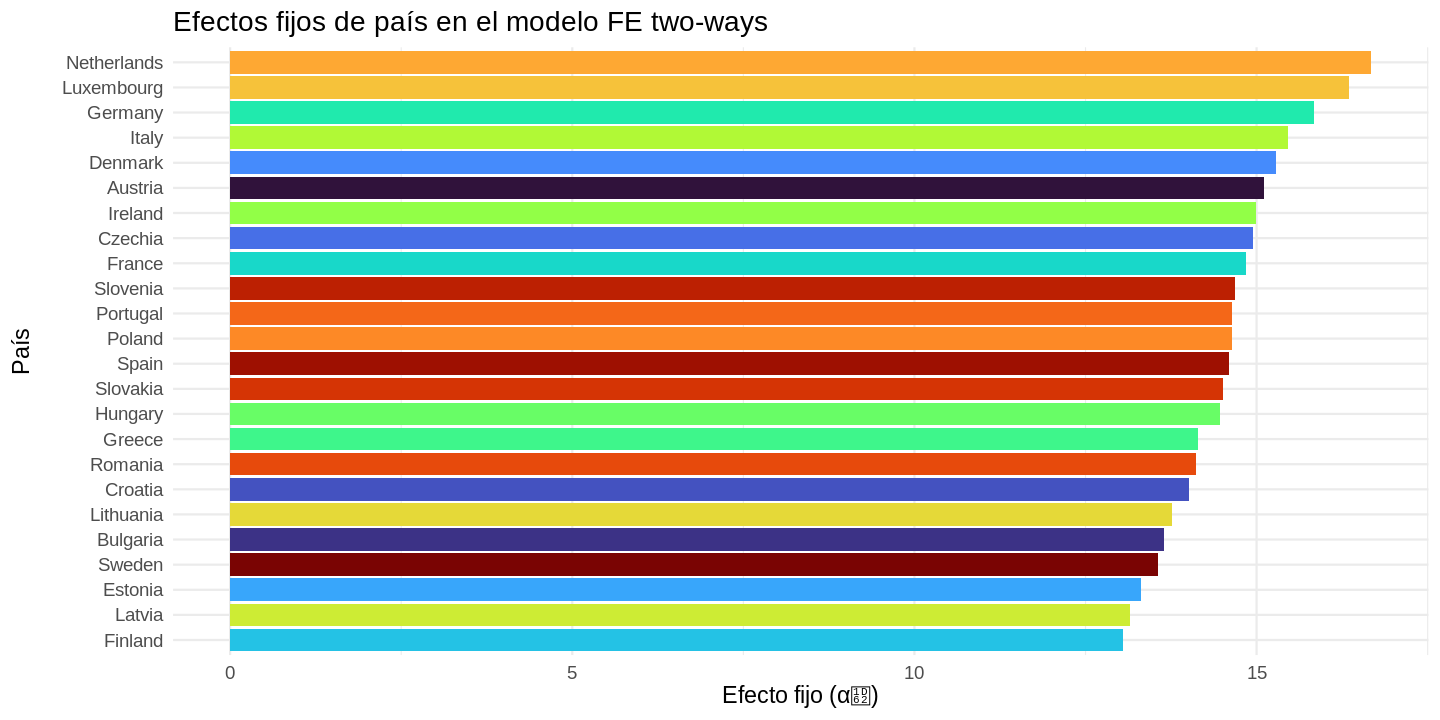

In [78]:
# 13. GRÁFICOS LIGADOS AL MODELO.

# 13.1. Efectos fijos de país (αᵢ) del modelo FE two-ways (Para mostrar diferencias estructurales entre países).
# (Países con αᵢ positivo tienen, ceteris paribus, un nivel de PIB per cápita sistemáticamente mayor al promedio condicional, y viceversa).

library(viridis)

ggplot(df_country, aes(x = reorder(Country, alpha_i), y = alpha_i, fill = Country)) +
  geom_col() +
  scale_fill_viridis_d(option = "turbo") +
  coord_flip() +
  labs(
    title = "Efectos fijos de país en el modelo FE two-ways",
    x = "País",
    y = "Efecto fijo (αᵢ)"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "none"
  )



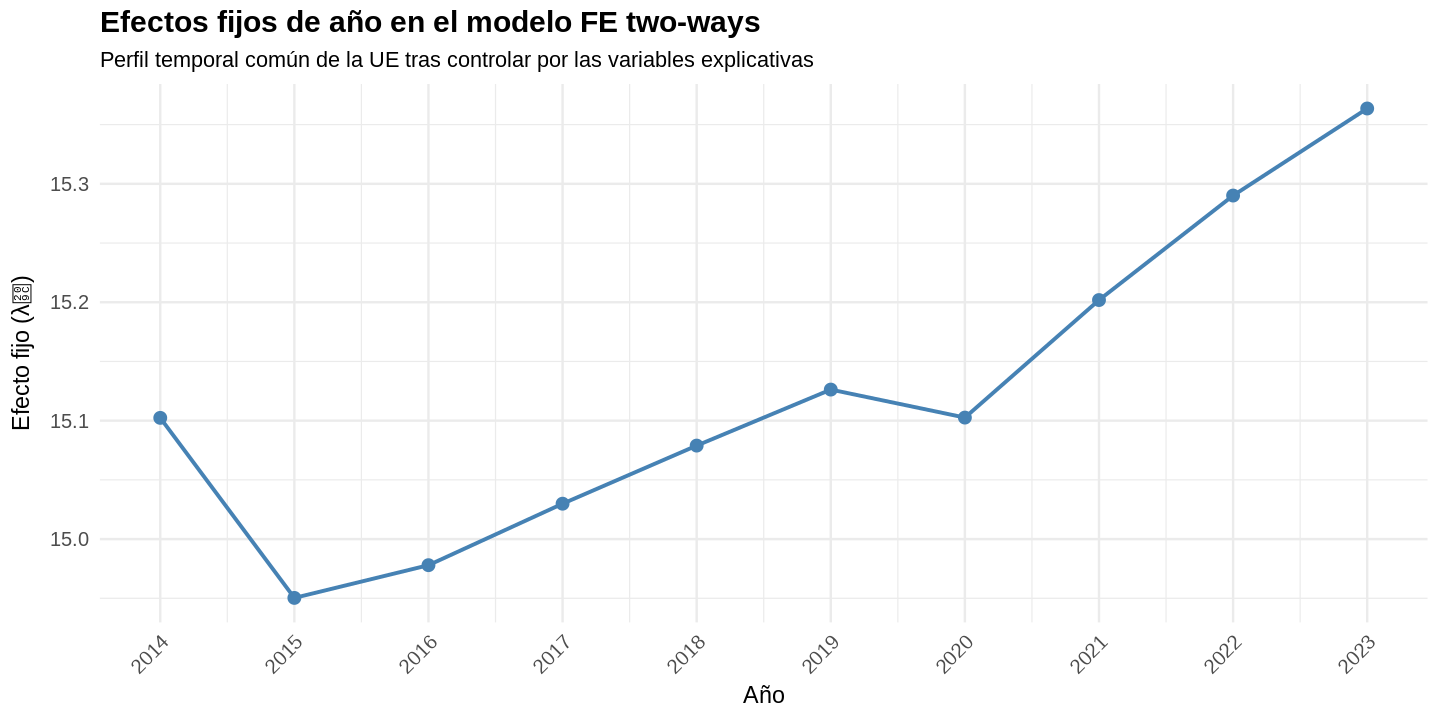

In [69]:
# 13.2. Efectos fijos de año (λₜ)
# (Perfil temporal común de la UE (crisis, recuperación, etc.) una vez controlado por las variables explicativas).

# Hacer la figura más grande en Colab
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(df_time, aes(x = Year, y = lambda_t)) +
  geom_line(linewidth = 1.1, color = "steelblue") +
  geom_point(size = 3, color = "steelblue") +
  labs(
    title    = "Efectos fijos de año en el modelo FE two-ways",
    subtitle = "Perfil temporal común de la UE tras controlar por las variables explicativas",
    x        = "Año",
    y        = "Efecto fijo (λₜ)"
  ) +
  scale_x_continuous(breaks = df_time$Year) +        # muestra todos los años
  theme_minimal(base_size = 15) +
  theme(
    plot.title    = element_text(size = 18, face = "bold"),
    plot.subtitle = element_text(size = 13),
    axis.title    = element_text(size = 14),
    axis.text.x   = element_text(angle = 45, hjust = 1)
  )




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



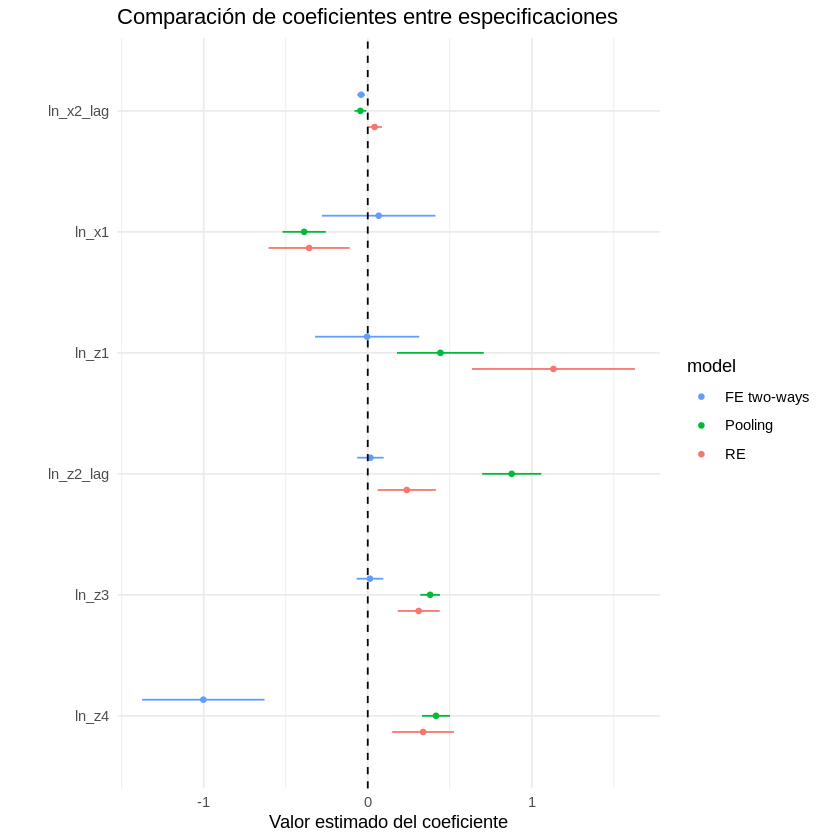

In [49]:
# 13.3. Coefplot sencillo FE vs Pooling vs RE
# (Se observa claramanete como ln_x2_lag cambia de signo entre modelos, reforzando la importancia de elegir FE (que es el consistente por Hausman)).


install.packages("dotwhisker")
install.packages("broom")   # por si no está
install.packages("ggplot2") # se asegura de tenerlo activado

library(dotwhisker)
library(broom)
library(ggplot2)

models_list <- list(
  "FE two-ways" = fe_tw,
  "Pooling"     = pool,
  "RE"          = re
)

dwplot(models_list) +
  theme_minimal() +
  labs(title = "Comparación de coeficientes entre especificaciones",
       x = "Valor estimado del coeficiente",
       y = "") +
  geom_vline(xintercept = 0, linetype = "dashed")


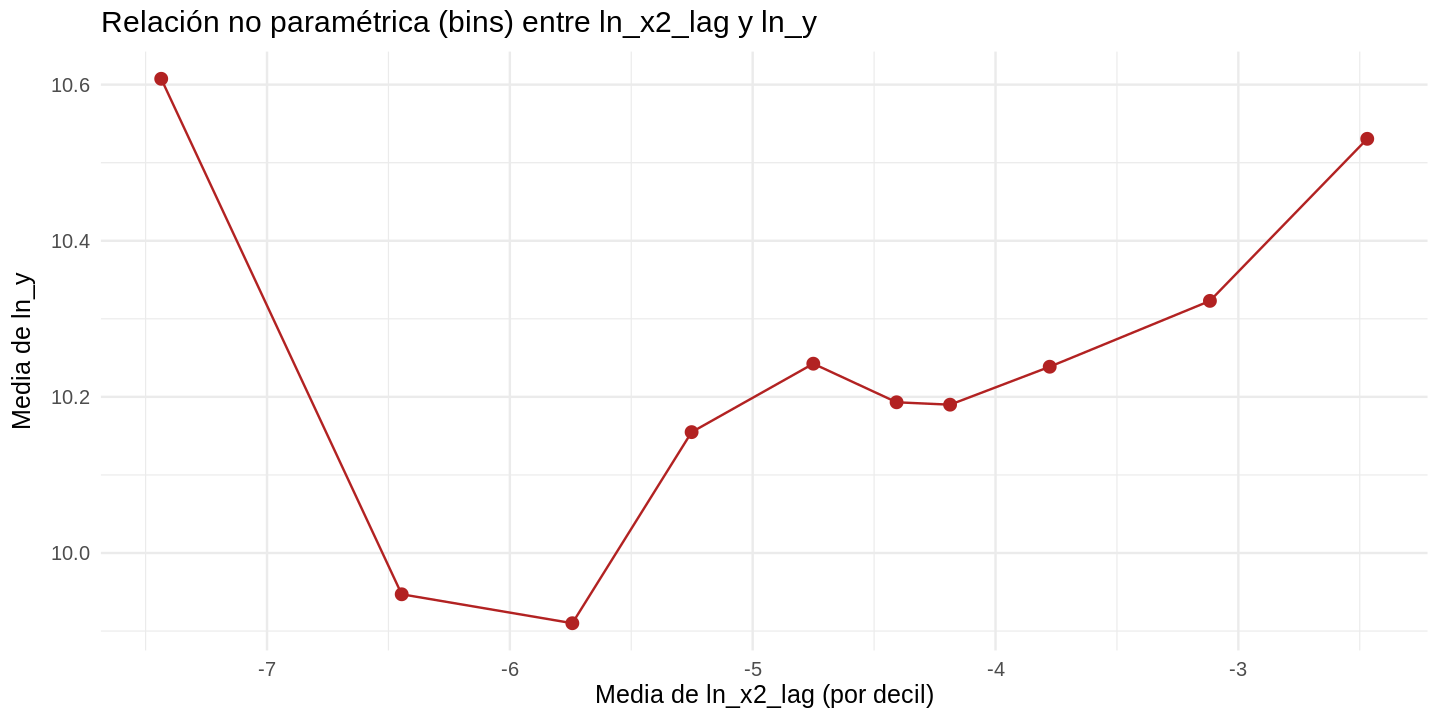

In [79]:
# 13.4. Medias por bins ("binned means") para ln_x2_lag → ln_y

library(dplyr)
library(ggplot2)

panel_bins <- panel %>%
  mutate(bin = ntile(ln_x2_lag, 10)) %>%
  group_by(bin) %>%
  summarise(
    ln_x2_lag_mean = mean(ln_x2_lag, na.rm = TRUE),
    ln_y_mean = mean(ln_y, na.rm = TRUE)
  )

ggplot(panel_bins, aes(x = ln_x2_lag_mean, y = ln_y_mean)) +
  geom_point(size = 3, color = "firebrick") +
  geom_line(color = "firebrick") +
  labs(
    title = "Relación no paramétrica (bins) entre ln_x2_lag y ln_y",
    x = "Media de ln_x2_lag (por decil)",
    y = "Media de ln_y"
  ) +
  theme_minimal(base_size = 15)

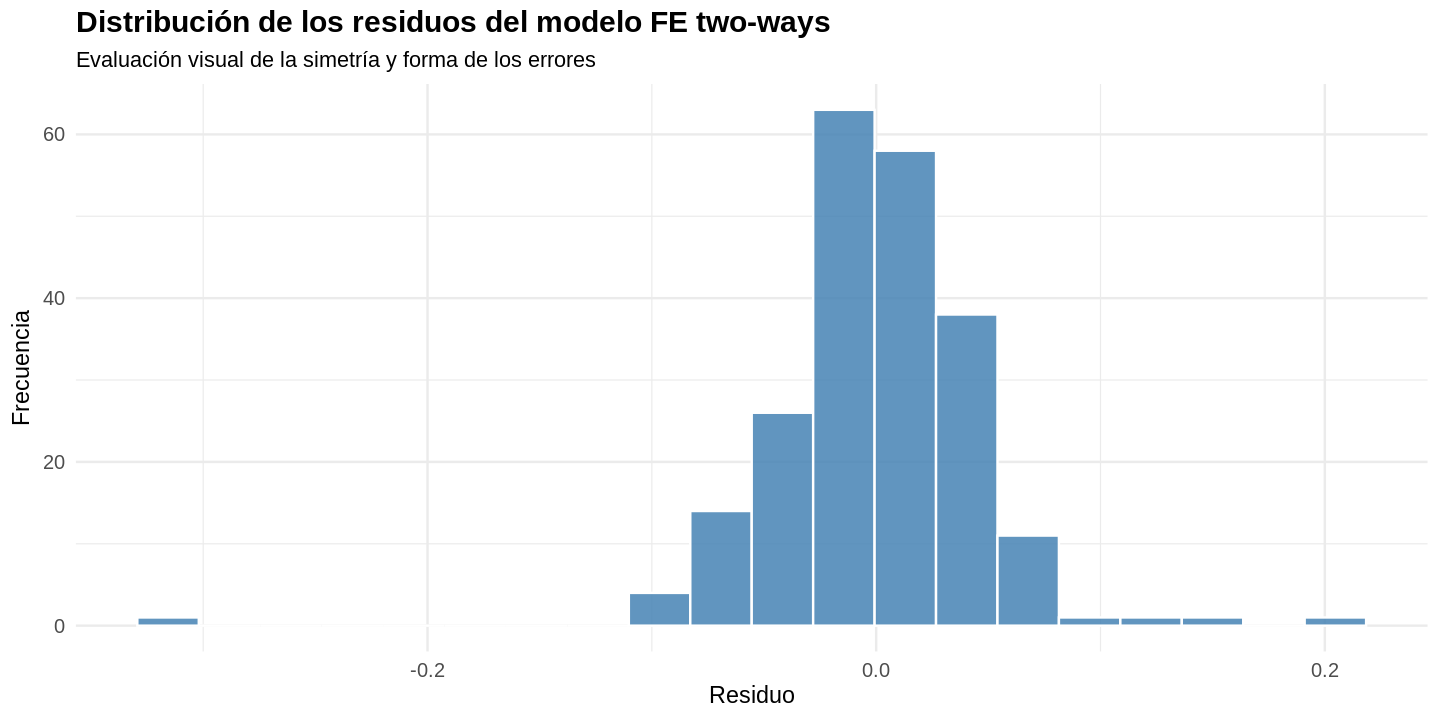

In [71]:
# 14. GRÁFICOS DE DIAGNÓSTICO

# 14.1. Histograma de residuos del FE two-ways

res_fe <- residuals(fe_tw)

ggplot(data.frame(res_fe = res_fe), aes(x = res_fe)) +
  geom_histogram(
    bins = 20,
    fill = "steelblue",      # color bonito y profesional
    color = "white",         # bordes blancos para claridad
    alpha = 0.85
  ) +
  labs(
    title    = "Distribución de los residuos del modelo FE two-ways",
    subtitle = "Evaluación visual de la simetría y forma de los errores",
    x        = "Residuo",
    y        = "Frecuencia"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title    = element_text(size = 18, face = "bold"),
    plot.subtitle = element_text(size = 13),
    axis.title    = element_text(size = 14)
  )



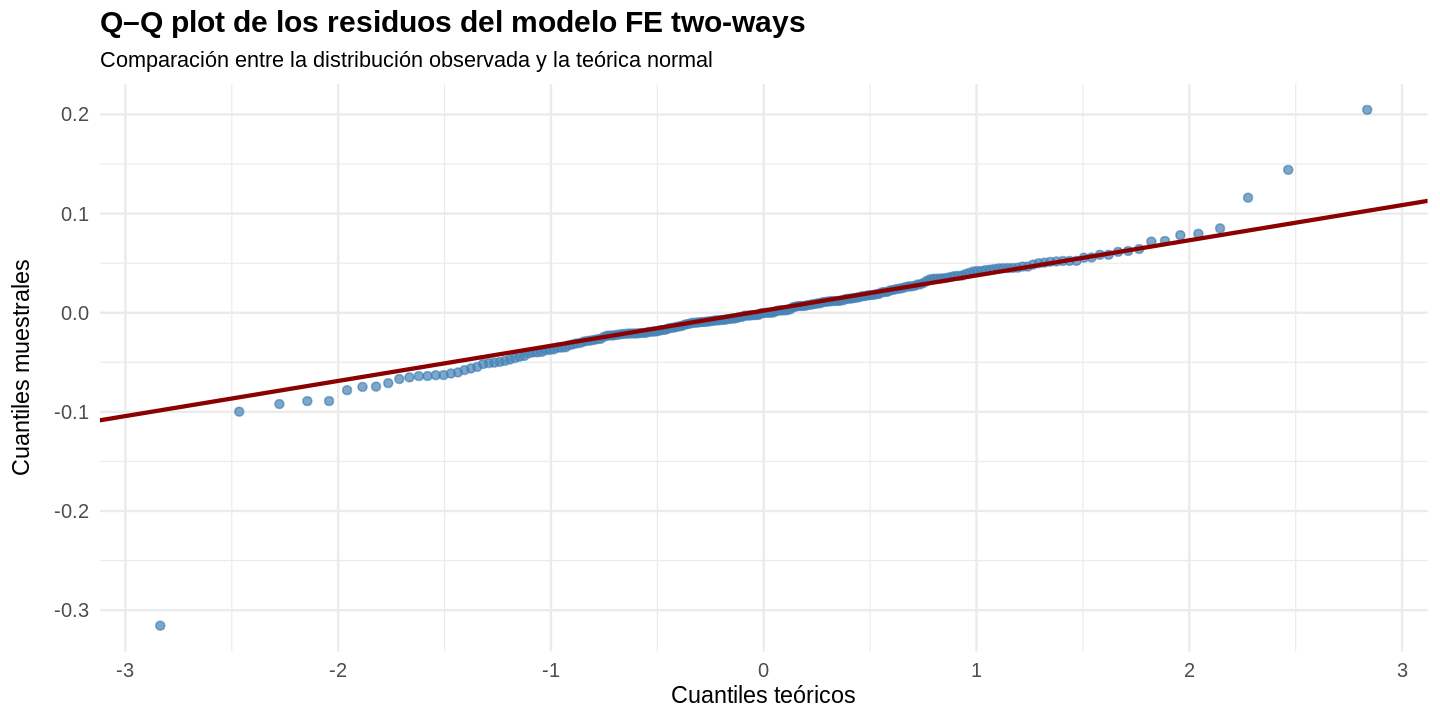

In [72]:
# 14. GRÁFICOS DE DIAGNÓSTICO

# 14.2 Q–Q plot de residuos

ggplot(data.frame(res_fe = res_fe), aes(sample = res_fe)) +
  stat_qq(color = "steelblue", size = 2, alpha = 0.7) +      # puntos más visibles
  stat_qq_line(color = "darkred", linewidth = 1.2) +         # línea de referencia fuerte
  labs(
    title    = "Q–Q plot de los residuos del modelo FE two-ways",
    subtitle = "Comparación entre la distribución observada y la teórica normal",
    x        = "Cuantiles teóricos",
    y        = "Cuantiles muestrales"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title    = element_text(size = 18, face = "bold"),
    plot.subtitle = element_text(size = 13),
    axis.title    = element_text(size = 14)
  )



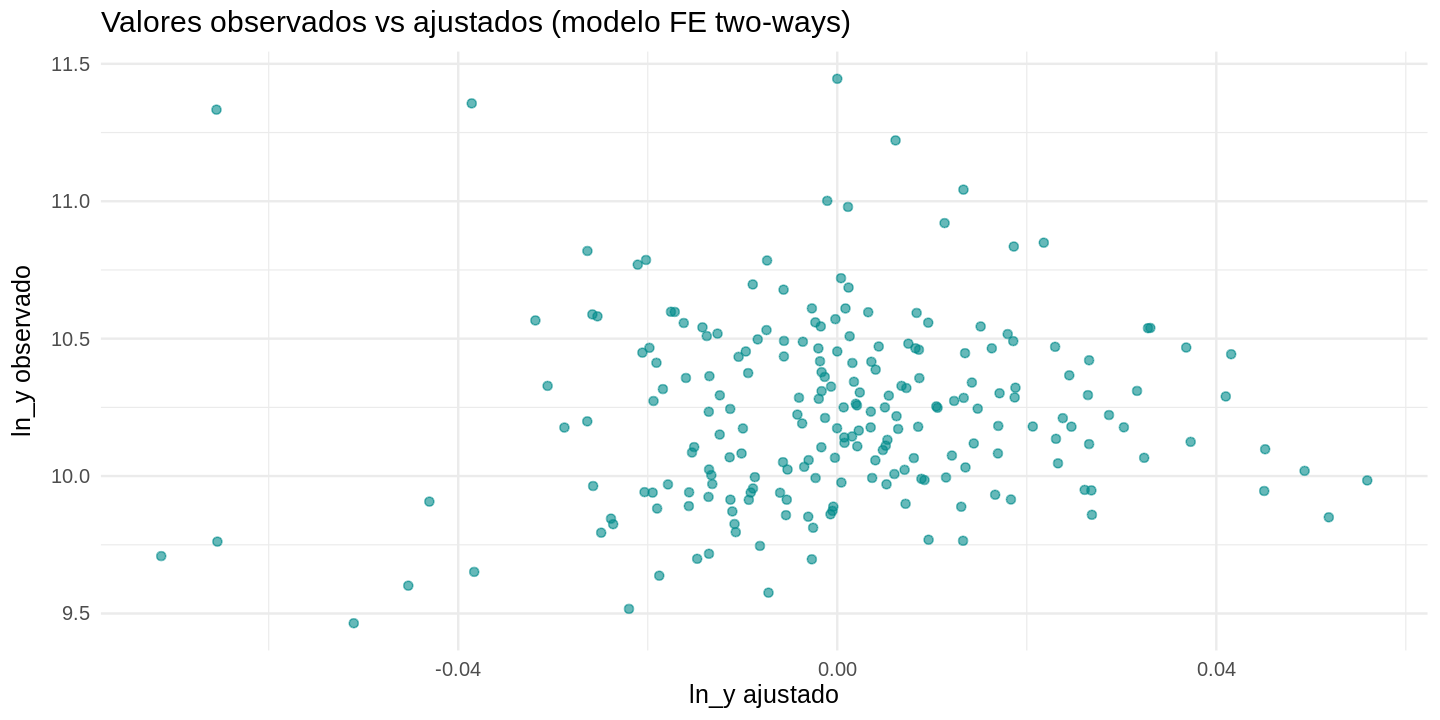

In [76]:
# Scatter “observado vs ajustado” del modelo FE

fitted_vals <- fitted(fe_tw)
actual_vals <- panel$ln_y

df_fit <- data.frame(actual = actual_vals, fitted = fitted_vals)

ggplot(df_fit, aes(x = fitted, y = actual)) +
  geom_point(alpha = 0.6, color = "darkcyan") +
  geom_abline(slope = 1, intercept = 0, color = "red", linewidth = 1) +
  labs(
    title = "Valores observados vs ajustados (modelo FE two-ways)",
    x = "ln_y ajustado",
    y = "ln_y observado"
  ) +
  theme_minimal(base_size = 15)
